# Understanding all-cause mortality in the United States using Generalized Linear Models

This notebook uses generalized linear modeling (GLM) to understand
mortality in different demographic subgroups, and its variation over
time.  The data are for the United States and are obtained from the
U.S. Centers for Disease Control (CDC).

See the `vital_stats_prep.py` script for more information about the
data, and to see the code used to assemble the data analyzed here.
You must run the `vital_stats_prep.py` script to create a data file
before running this script.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

This is the path to the data file on your system.  You will need to
change this to match the path used in the `vital_stats_prep.py`
script.

In [2]:
pa = "/nfs/kshedden/cdc_mortality/final/pop_mort.csv"
df = pd.read_csv(pa)

All of the GLM's we will be using here use the logarithm as their
link function.  Therefore we will use log-transformed population as
an offset, so that mortality is expressed relative to the population
size.

In [3]:
df.loc[:, "offset"] = np.log(df.Population)

A very important property that follows from using a model with the
log link function is that the regression effects are multiplicative.
In our setting, this means that the overall mortality is represented
as a product of terms, rather than as a sum of terms (which is the
case in some other forms of regression analysis).  For example,
suppose that a model tells use that men have 1.05 times greater risk
of dying than women.  This multiplicative factor adjusts the base
rate of death defined by the other variables.  So if the death rate
in January is 1.03 times greater than the death rate in June, we can
combine this with the multiplicative factor for sex to obtain that
the death rate for men in January is 1.05*1.03 times the death rate
for women in June.

The above discussion applies to models with no interactions.  If
there are interactions, then the morality for men in January could
be either greater than, or less than 1.05*1.03, depending on the
sign and magnitude of the interaction term.

We begin by fitting an initial Poisson GLM treating all counts as
being independent.

In [4]:
fml = "Deaths ~ Age_group + Sex + C(Year) + C(Month)"
m1 = sm.GLM.from_formula(fml, family=sm.families.Poisson(), offset=df.offset, data=df)
r1 = m1.fit(scale="X2")

Next we use generalized estimating equations (GEE) to fit a model in
which counts within the same year/month are independent.  Note that
many of the standard errors are larger in the GEE analysis compared
to the GLM analysis.  This is expected since dependence between
measured values often reduces the information in the data.

In [5]:
df["yearmonth"] = 20*df.Year + df.Month
m2 = sm.GEE.from_formula(fml, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.offset, cov_struct=sm.cov_struct.Independence(), data=df)
r2 = m2.fit()

Next we fit a series of models in which we consider pairwise
interactions between different types of variables.  In each case we
use a score test to assess the evidence that the moderating
relationship is real.  We begin by consider whether age-specific
mortality rates vary by sex.  The score test results indicate that
there is strong evidence for this.

In [6]:
fml3 = "Deaths ~ Age_group * Sex + C(Year) + C(Month)"
m3 = sm.GEE.from_formula(fml3, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.offset, cov_struct=sm.cov_struct.Independence(), data=df)
r3 = m3.fit()

print(m3.compare_score_test(r2))
#-

# Next we assess whether the seasonality patterns vary by sex.  There
# is strong evidence for this moderation as well.

{'statistic': 143.3509118764921, 'df': 17, 'p-value': 0.0}


In [7]:
fml4 = "Deaths ~ (Age_group + C(Month)) * Sex + C(Year)"
m4 = sm.GEE.from_formula(fml4, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.offset, cov_struct=sm.cov_struct.Independence(), data=df)
r4 = m4.fit()

print(m4.compare_score_test(r3))
#-

# There is also strong evidence that the long term trend varies by
# sex.

{'statistic': 56.97281165814371, 'df': 11, 'p-value': 3.3659033782384995e-08}


In [8]:
fml5 = "Deaths ~ (Age_group + C(Year) + C(Month)) * Sex"
m5 = sm.GEE.from_formula(fml5, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.offset, cov_struct=sm.cov_struct.Independence(), data=df)
r5 = m5.fit(scale="X2")

print(m5.compare_score_test(r4))
#-

# Below we check whether the sex-specific seasonality patterns vary by
# year.  There isn't much evidence for this form of moderation.

{'statistic': 72.83475421673036, 'df': 11, 'p-value': 3.5209168913752364e-11}


In [9]:
fml6 = "Deaths ~ (Age_group + C(Year) * C(Month)) * Sex"
m6 = sm.GEE.from_formula(fml6, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.offset, cov_struct=sm.cov_struct.Independence(), data=df)
r6 = m6.fit()

print(m6.compare_score_test(r5))
#-

# Now that we have used hypothesis testing to assess which moderating
# effects might be real, we can look at the effects sizes to
# understand the patterns of moderation in more detail.  First, we
# plot the age group effects by sex.  The values plotted on the
# vertical axis can be differenced to obtain log risk ratios.  These
# results hold for all months and all years.

{'statistic': 143.99999999824558, 'df': 242, 'p-value': 0.9999999128073275}


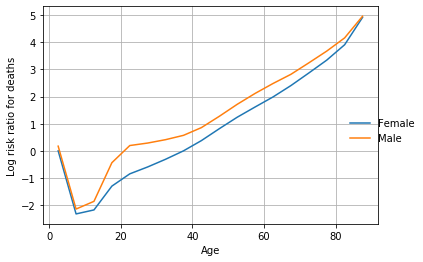

In [10]:
# These are the ages that are plotted along the horizontal axis
ages = ["%02d_%02d" % (a, a+4) for a in range(5, 90, 5)]
an = [a+2.5 for a in range(0, 90, 5)]
ages[-1] = "85_99"

# These are the parameters that we will use to obtain log risk ratios.
pa = r5.params.to_dict()

# These are the contributions of age and sex to the model.
xf = [0] + [pa['Age_group[T.%s]' % a] for a in ages]
xm = [0] + [pa['Age_group[T.%s]:Sex[T.Male]' % a] for a in ages]
xf = np.asarray(xf)
xm = np.asarray(xm)
xm += pa['Sex[T.Male]']

# Plot the age and sex effects
plt.grid(True)
plt.plot(an, xf, label="Female")
plt.plot(an, xf + xm, label="Male")
plt.xlabel("Age")
plt.ylabel("Log risk ratio for deaths")
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "center right")
leg.draw_frame(False)

Next we plot the male/female log risk ratio by age group.  This
shows how much more likely a male is to die than a female in each
month.  This effect holds for all age groups in all years.

Text(0, 0.5, 'Log risk ratio for deaths')

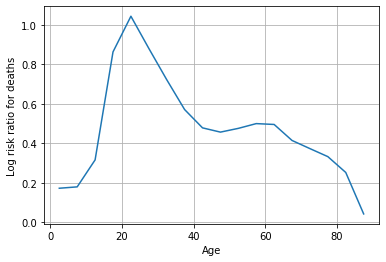

In [11]:
plt.grid(True)
plt.plot(an, xm, label="Male")
plt.xlabel("Age")
plt.ylabel("Log risk ratio for deaths")

Next we consider the mortality risk by month for females and males.
This reflects a seasonal pattern of mortality.  To obtain a risk
ratio between any two groups, subtract the log risk values in the
plot below and exponentiate this difference.

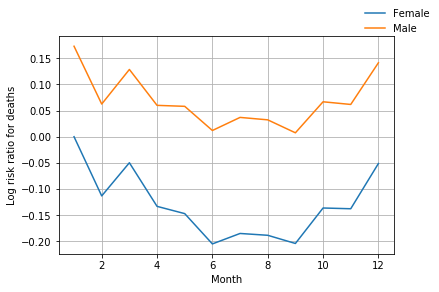

In [12]:
months = range(1, 13)
xf = [0] + [pa['C(Month)[T.%d]' % m] for m in range(2, 13)]
xm = [0] + [pa['C(Month)[T.%d]:Sex[T.Male]' % m] for m in range(2, 13)]
xf = np.asarray(xf)
xm = np.asarray(xm)
xm += pa['Sex[T.Male]']

plt.grid(True)
plt.plot(months, xf, label="Female")
plt.plot(months, xf + xm, label="Male")
plt.xlabel("Month")
plt.ylabel("Log risk ratio for deaths")
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb)
leg.draw_frame(False)

Plot the male/female log risk ratio by month.

Text(0, 0.5, 'Log risk ratio for deaths')

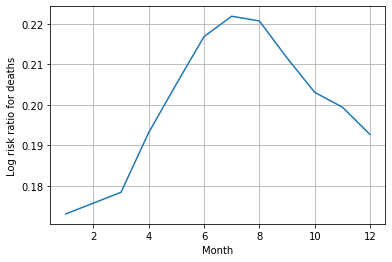

In [13]:
plt.grid(True)
plt.plot(months, xm, label="Male")
plt.xlabel("Month")
plt.ylabel("Log risk ratio for deaths")
#-

# Next we consider any "long term trend" in the data, that is,
# patterns of mortality variation that evolve continuously over
# multiple years.  To assess this, we first plot the female and male
# log risk ratio for death by year.  To obtain a ris ratio, take the
# difference between any two points on these curves and exponentiate
# it.

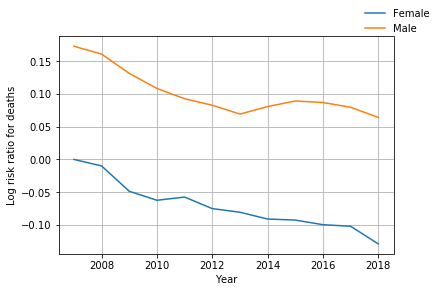

In [14]:
# These are the contributions of age and sex to the model.
years = range(2008, 2019)
xf = [0] + [pa['C(Year)[T.%4d]' % y] for y in years]
xm = [0] + [pa['C(Year)[T.%4d]:Sex[T.Male]' % y] for y in years]
xf = np.asarray(xf)
xm = np.asarray(xm)
xm += pa['Sex[T.Male]']

plt.grid(True)
years = [2007] + list(years)
plt.plot(years, xf, label="Female")
plt.plot(years, xf + xm, label="Male")
plt.xlabel("Year")
plt.ylabel("Log risk ratio for deaths")
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb)
leg.draw_frame(False)

Plot the male/female log risk ratio by year

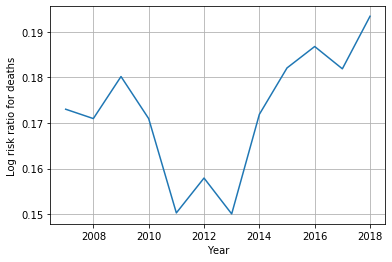

In [15]:
plt.grid(True)
plt.plot(years, xm, label="Male")
plt.xlabel("Year")
plt.ylabel("Log risk ratio for deaths")
#-

# # Residual analysis

lp = np.dot(m5.exog, r5.params) + m5.offset
fv = np.exp(lp)
re = m5.endog - fv
pr = re / np.sqrt(r5.scale * fv)